Pada pertemuan sebelumnya, kita sudah membahas terkait diagnostik dan asumsi sisaan yang harus dipenuhi dari model regresi linear. Asumsi-asumsi tersebut tidak lain adalah sebagai berikut,

1.  Nilai harapan galat sama dengan nol $(E[\varepsilon_i]=0)$

2.  Homoskedastisitas atau ragam galat homogen $(var[\varepsilon]=\sigma^2I)$

3.  Autokorelasi atau galat saling bebas $(E[\varepsilon_i,\varepsilon_j]=0)$

4.  Galat menyebar Normal $(\varepsilon∼N(0,\sigma^2I))$

5.  Tidak ada multikolinearitas antarpeubah bebas $(cov(x_i,x_j)=0,\forall{i}\neq{j})$

Jika ditemukan adanya asumsi-asumsi yang dilanggar pada proses analisis, diperlukan adanya penanganan kondisi tak standar. Pada pertemuan kali ini, akan dibahas penanganan kondisi tak standar sederhana pada dataset `state.x77`.

In [59]:
import pandas as pd

# URL untuk mengunduh dataset state.x77
url = "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/state.x77.csv"

data = pd.read_csv(url, index_col=0)
data = data[['Income'] + [col for col in data.columns if col != 'Income']]
data = data.drop(data.columns[6], axis=1)

print(data)

                Income  Population  Illiteracy  Life Exp  Murder  HS Grad  \
rownames                                                                    
Alabama           3624        3615         2.1     69.05    15.1     41.3   
Alaska            6315         365         1.5     69.31    11.3     66.7   
Arizona           4530        2212         1.8     70.55     7.8     58.1   
Arkansas          3378        2110         1.9     70.66    10.1     39.9   
California        5114       21198         1.1     71.71    10.3     62.6   
Colorado          4884        2541         0.7     72.06     6.8     63.9   
Connecticut       5348        3100         1.1     72.48     3.1     56.0   
Delaware          4809         579         0.9     70.06     6.2     54.6   
Florida           4815        8277         1.3     70.66    10.7     52.6   
Georgia           4091        4931         2.0     68.54    13.9     40.6   
Hawaii            4963         868         1.9     73.60     6.2     61.9   

# Pemodelan Regresi Linear

## Eksplorasi Data

Eksplorasi paling dasar dalam proses analisis regresi adalah pengecekan sebaran tiap peubah dan deteksi potensi amatan anomali (pencilan maupun leverage). Tiap peubah tentunya diharapkan menyebar (atau menyerupai sebaran) Normal dan bebas dari amatan anomali.

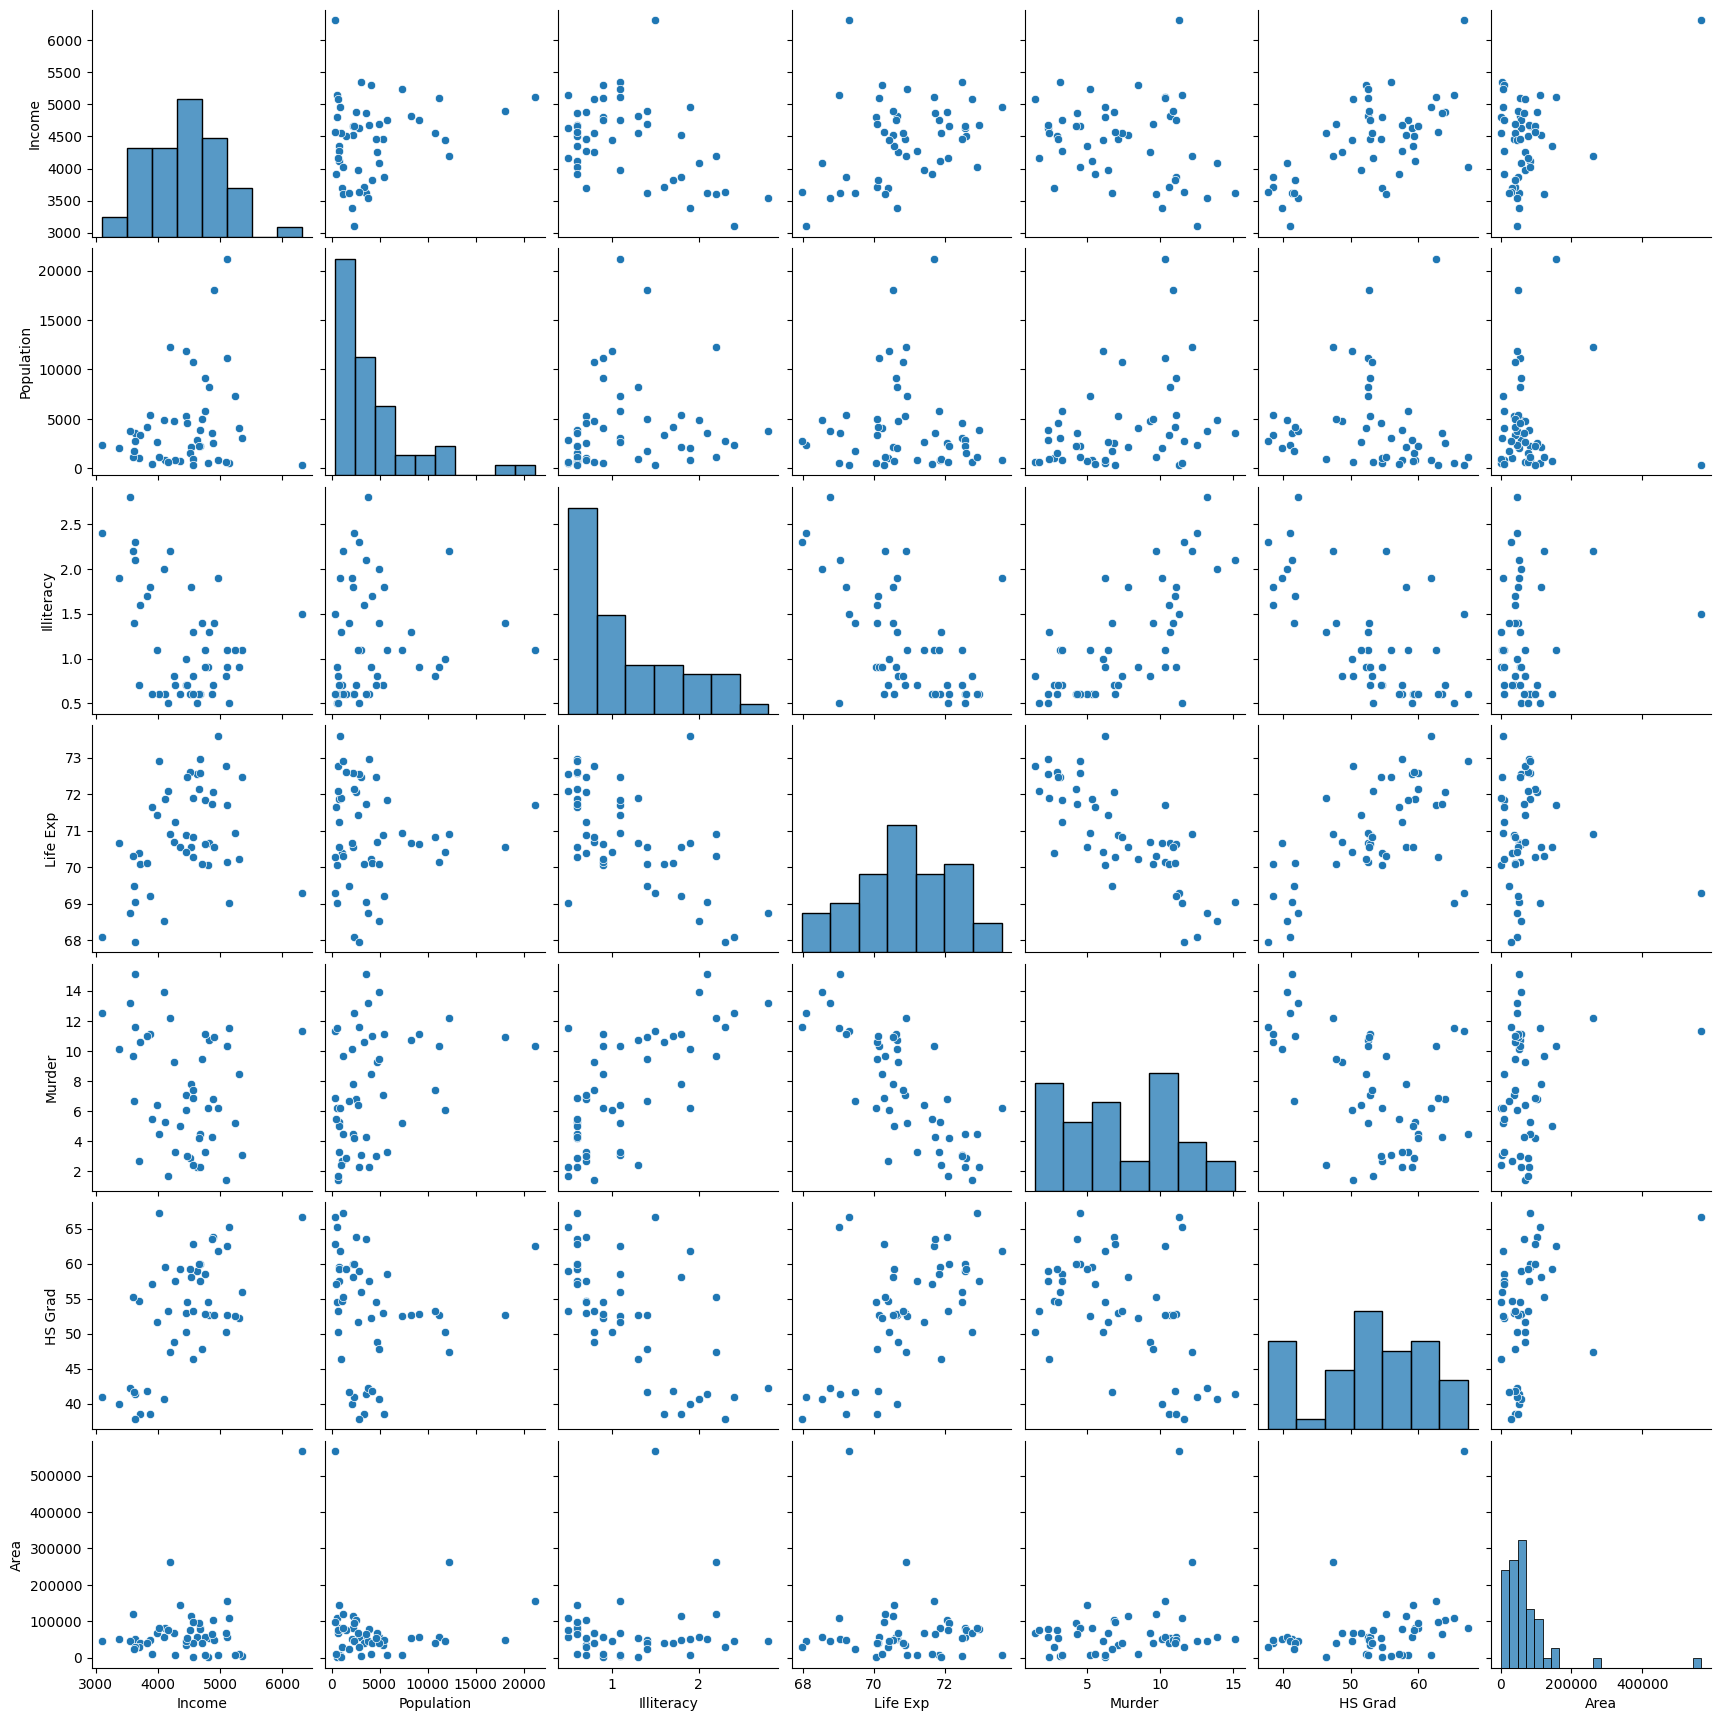

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data)
plt.show()

## Pemodelan Regresi Linear

In [61]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(data.drop('Income', axis=1))
y = data['Income']
model = sm.OLS(y, X).fit()

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

     Variable          VIF
0       const  9653.706239
1  Population     1.368406
2  Illiteracy     2.974850
3    Life Exp     3.510591
4      Murder     4.852331
5     HS Grad     2.955145
6        Area     1.539652


Setelah dilakukan pengujian, diketahui bahwa tidak terdapat multikolinearitas antarpeubah penjelas. **Hal ini diindikasikan oleh nilai VIF \< 10 pada seluruh peubah penjelas yang digunakan.**


In [62]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     7.114
Date:                Sel, 11 Mar 2025   Prob (F-statistic):           2.62e-05
Time:                        07:02:10   Log-Likelihood:                -374.24
No. Observations:                  50   AIC:                             762.5
Df Residuals:                      43   BIC:                             775.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3411.3046   6456.710      0.528      0.6

Pemodelan menggunakan seluruh peubah menyiratkan bahwa terdapat beberapa peubah penjelas yang tidak berpengaruh signifikan dalam taraf nyata $5\%$ terhadap peubah respons. Jika kita mengharapkan pembentukan model regresi yang terbaik dan mampu menghasilkan informasi terkait peubah-peubah yang memengaruhi peubah respons, perlu dilakukan seleksi peubah pada model yang kita bangun. Terdapat setidaknya tiga metode seleksi peubah yang sering digunakan, yaitu metode *backward*, *forward*, dan *stepwise*.

# Seleksi Peubah

## Metode Backward

Prosedur seleksi peubah dengan metode *backward* berjalan sebagai berikut,

1.  Langkah dimulai dengan melakukan pemodelan terhadap seluruh peubah penjelas yang kita punya

2.  Selanjutnya, satu per satu peubah penjelas akan dieliminasi berdasarkan nilai F-parsial yang paling besar (paling tidak berpengaruh signifikan) terhadap peubah respons

3.  Peubah penjelas yang telah dieliminasi tidak akan dikembalikan dalam model

4.  Eliminasi peubah penjelas terus dilakukan hingga diperoleh model terbaik berdasarkan metrik yang diacu (biasanya AIC)

In [64]:
# Function for backward stepwise regression
def backward_stepwise_regression(data, response, significance_level=0.05):
    # Start with all predictors
    predictors = data.columns.tolist()
    predictors.remove(response)
    
    # Fit the initial model
    formula = f"{response} ~ " + " + ".join(predictors)
    model = sm.OLS(data[response], sm.add_constant(data[predictors])).fit()
    
    while True:
        # Get the p-values of the model
        p_values = model.pvalues[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        
        # If the highest p-value is greater than the significance level, remove that predictor
        if max_p_value > significance_level:
            excluded_predictor = p_values.idxmax()
            predictors.remove(excluded_predictor)
            formula = f"{response} ~ " + " + ".join(predictors)
            model = sm.OLS(data[response], sm.add_constant(data[predictors])).fit()
        else:
            break
    
    return model

# Perform backward stepwise regression
backward_model = backward_stepwise_regression(data, 'Income')

# Display the summary of the final model
print(backward_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     19.82
Date:                Sel, 11 Mar 2025   Prob (F-statistic):           5.72e-07
Time:                        07:02:21   Log-Likelihood:                -376.19
No. Observations:                  50   AIC:                             758.4
Df Residuals:                      47   BIC:                             764.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1663.9734    451.578      3.685      0.0

Berdasarkan prosedur seleksi peubah dengan metode *backward*, model terbaik yang terbentuk adalah model dengan dua peubah penjelas. Kedua peubah penjelas itu adalah Population, dan HS Grad.

## Metode Forward

Prosedur seleksi peubah dengan metode *forward* berjalan sebagai berikut,

1.  Langkah dimulai dengan melakukan pemodelan hanya terhadap intersep

2.  Selanjutnya, satu per satu peubah penjelas akan dimasukkan ke model berdasarkan nilai koefisien korelasi yang paling besar terhadap peubah respons

3.  Peubah penjelas yang telah dimasukkan tidak akan dieliminasi dari model

4.  Imputasi peubah penjelas terus dilakukan hingga diperoleh model terbaik berdasarkan metrik yang diacu (biasanya AIC)

In [65]:
def forward_stepwise_regression(data, response):
    # Start with an intercept-only model
    predictors = []
    remaining_predictors = data.columns.tolist()
    remaining_predictors.remove(response)
    
    # Initialize the best model
    best_aic = float('inf')
    best_model = None
    
    while remaining_predictors:
        aic_values = {}
        
        # Evaluate each predictor
        for predictor in remaining_predictors:
            current_predictors = predictors + [predictor]
            formula = f"{response} ~ " + " + ".join(current_predictors)
            model = sm.OLS(data[response], sm.add_constant(data[current_predictors])).fit()
            aic_values[predictor] = model.aic
        
        # Find the predictor with the lowest AIC
        best_predictor = min(aic_values, key=aic_values.get)
        best_aic_candidate = aic_values[best_predictor]
        
        # If the best AIC candidate is better than the current best, update the model
        if best_aic_candidate < best_aic:
            best_aic = best_aic_candidate
            predictors.append(best_predictor)
            remaining_predictors.remove(best_predictor)
            best_model = sm.OLS(data[response], sm.add_constant(data[predictors])).fit()
        else:
            break
    
    return best_model

# Perform forward stepwise regression
forward_model = forward_stepwise_regression(data, 'Income')

# Display the summary of the final model
print(forward_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     14.16
Date:                Sel, 11 Mar 2025   Prob (F-statistic):           1.14e-06
Time:                        07:02:23   Log-Likelihood:                -375.12
No. Observations:                  50   AIC:                             758.2
Df Residuals:                      46   BIC:                             765.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1806.6519    458.099      3.944      0.0

Berdasarkan prosedur seleksi peubah dengan metode *forward*, model terbaik yang terbentuk adalah model dengan tiga peubah penjelas. Ketiga peubah penjelas itu adalah HS Grad, Population, dan Area.

## Metode Stepwise

Sementara itu, prosedur seleksi peubah *stepwise* merupakan kombinasi antara metode *backward* dan *forward*. Model pertama yang dibentuk adalah model dengan seluruh peubah penjelas yang kemudian akan dieliminasi satu per satu. Meskipun demikian, peubah yang telah dieliminasi masih memiliki kemungkinan untuk diimputasi kembali ke dalam model.

In [66]:
def bidirectional_stepwise_regression(data, response):
    # Start with all predictors
    predictors = data.columns.tolist()
    predictors.remove(response)
    
    # Initialize the best model
    best_aic = float('inf')
    best_model = None
    
    while True:
        # Forward step
        forward_aic = best_aic
        forward_predictors = predictors.copy()
        remaining_predictors = [col for col in data.columns if col != response and col not in predictors]
        
        for predictor in remaining_predictors:
            current_predictors = predictors + [predictor]
            formula = f"{response} ~ " + " + ".join(current_predictors)
            model = sm.OLS(data[response], sm.add_constant(data[current_predictors])).fit()
            if model.aic < forward_aic:
                forward_aic = model.aic
                forward_predictors = current_predictors
                best_model = model
        
        # Backward step
        backward_aic = best_aic
        backward_predictors = predictors.copy()
        
        for predictor in predictors:
            current_predictors = [p for p in predictors if p != predictor]
            formula = f"{response} ~ " + " + ".join(current_predictors)
            model = sm.OLS(data[response], sm.add_constant(data[current_predictors])).fit()
            if model.aic < backward_aic:
                backward_aic = model.aic
                backward_predictors = current_predictors
                best_model = model
        
        # Update predictors
        if forward_aic < best_aic:
            predictors = forward_predictors
            best_aic = forward_aic
        elif backward_aic < best_aic:
            predictors = backward_predictors
            best_aic = backward_aic
        else:
            break
    
    return best_model

# Perform bidirectional stepwise regression
stepwise_model = bidirectional_stepwise_regression(data, 'Income')

# Display the summary of the final model
print(stepwise_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     14.16
Date:                Sel, 11 Mar 2025   Prob (F-statistic):           1.14e-06
Time:                        07:02:27   Log-Likelihood:                -375.12
No. Observations:                  50   AIC:                             758.2
Df Residuals:                      46   BIC:                             765.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1806.6519    458.099      3.944      0.0

Berdasarkan prosedur seleksi peubah dengan metode *stepwise*, model terbaik yang terbentuk adalah model dengan tiga peubah penjelas. Ketiga peubah penjelas itu adalah Population, HS Grad, dan Area.

In [69]:
backward_aic = backward_model.aic
forward_aic = forward_model.aic
stepwise_aic = stepwise_model.aic

# Create a DataFrame to show AIC values
aic_values_df = pd.DataFrame({
    'Model': ['Backward', 'Forward', 'Stepwise'],
    'AIC': [backward_aic, forward_aic, stepwise_aic]
})

# Display the DataFrame
print(aic_values_df)

      Model         AIC
0  Backward  758.377623
1   Forward  758.249813
2  Stepwise  758.249813


## Diagnostik Sisaan Model Terbaik

Selanjutnya akan dibentuk model terbaik, yaitu model yang telah melalui prosedur seleksi peubah. Sisaan model ini kemudian akan didiagnostik menggunakan beberapa uji formal.

In [70]:
model2 = sm.OLS(data['Income'], sm.add_constant(data[['Population', 'HS Grad', 'Area']])).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     14.16
Date:                Sel, 11 Mar 2025   Prob (F-statistic):           1.14e-06
Time:                        07:03:27   Log-Likelihood:                -375.12
No. Observations:                  50   AIC:                             758.2
Df Residuals:                      46   BIC:                             765.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1806.6519    458.099      3.944      0.0

### Autkorelasi Sisaan: Durbin-Watson

Uji formal untuk mendeteksi autokorelasi sisaan dapat dilakukan dengan uji Durbin-Watson menggunakan fungsi `durbin_watson`. Uji ini memiliki hipotesis sebagai berikut,

$H_0:E[\varepsilon_i,\varepsilon_j]=0$ (tidak ada autokorelasi)

$H_1:E[\varepsilon_i,\varepsilon_j]\neq0$ (terdapat autokorelasi)

In [71]:
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(model2.resid)

# Display the Durbin-Watson statistic
print(f'Durbin-Watson Statistic: {dw_statistic}')

# Interpretation of the result
if dw_statistic < 1.5:
    print("Ada Autokorelasi")
elif dw_statistic > 2.5:
    print("Ada Autokorelasi")
else:
    print("Tidak Ada Autokorelasi")

Durbin-Watson Statistic: 2.0267646443963288
Tidak Ada Autokorelasi


Nilai p-value $> 0,05$ bermakna taktolak $H_0$. Hal ini mengindikasikan bahwa dalam taraf nyata $5\%$, tidak cukup bukti untuk menyatakan bahwa terdapat autokorelasi dalam sisaan.

### Homogenitas: Breusch-Pagan

Uji formal untuk mendeteksi homogenitas ragam sisaan dapat dilakukan dengan uji Breusch-Pagan menggunakan fungsi `het_breuschpagan`. Uji ini memiliki hipotesis sebagai berikut,

$H_0:var[\varepsilon]=\sigma^2I$ (ragam homogen)

$H_1:var[\varepsilon]\neq\sigma^2I$ (ragam tidak homogen)

In [72]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model2.resid, model2.model.exog)

# Extract the p-value
bp_p_value = bp_test[1]

# Display the result of the test
result = "Ragam Tidak Homogen" if bp_p_value < 0.05 else "Ragam Homogen"
print(f"Breusch-Pagan Test p-value: {bp_p_value:.4f} - {result}")

Breusch-Pagan Test p-value: 0.3441 - Ragam Homogen


Nilai p-value $>0,05$ bermakna taktolak $H_0$. Hal ini mengindikasikan bahwa dalam taraf nyata $5\%$, tidak cukup bukti untuk menyatakan bahwa ragam sisaan tidak homogen.

### Normalitas: Kolmogorov-Smirnov

Uji formal untuk mendeteksi normalitas sisaan dapat dilakukan dengan uji Kolmogorov-Smirnov menggunakan fungsi `kstest`. Menghitung perbedaan maksimum antara distribusi kumulatif empiris dari data sampel dan distribusi kumulatif dari distribusi normal yang diharapkan. Uji ini memiliki hipotesis sebagai berikut,

$H_0:F(x)=F_0(x)$ (sisaan menyebar Normal)

$H_1:F(x)\neq{F_0(x)}$ (sisaan tidak menyebar Normal)

In [73]:
from scipy import stats

lilliefors_statistic, p_value = stats.kstest(model2.resid, 'norm', args=(model2.resid.mean(), model2.resid.std()))
print(f"Lilliefors Test Statistic: {lilliefors_statistic}, p-value: {p_value}")

# Interpretation of the result
if p_value < 0.05:
    print("Sisaan Tidak Menyebar Normal")
else:
    print("Sisaan Menyebar Normal")

Lilliefors Test Statistic: 0.14524702796302347, p-value: 0.21970441509015082
Sisaan Menyebar Normal


Nilai p-value $>0,05$ bermakna terima $H_0$. Hal ini mengindikasikan bahwa dalam taraf nyata $5\%$, cukup bukti untuk menyatakan bahwa sisaan menyebar Normal.

### Normalitas: Shapiro-Wilk

Uji formal untuk mendeteksi normalitas sisaan juga dapat dilakukan dengan uji Shapiro-Wilk menggunakan fungsi `shapiro.test`. Khusus dirancang untuk menguji normalitas dan lebih sensitif terhadap penyimpangan dari normalitas, terutama untuk sampel kecil.

In [ ]:
shapiro_test = stats.shapiro(model2.resid)
print(f"Shapiro-Wilk Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
# Interpret the results
if shapiro_test.pvalue < 0.05:
    result = "Sisaan Tidak Menyebar Normal"
else:
    result = "Sisaan Menyebar Normal"

# Print the result
print(result)

Shapiro-Wilk Statistic: 0.9611010144976848, p-value: 0.0988593899079077
Sisaan Menyebar Normal


Nilai p-value $>0,05$ bermakna terima $H_0$. Hal ini mengindikasikan bahwa dalam taraf nyata $5\%$, cukup bukti untuk menyatakan bahwa sisaan menyebar Normal.

# Penanganan Kondisi Tak Standar

## Transformasi Box-Cox

Salah satu langkah penanganan kondisi takstandar berupa normalitas sisaan adalah transformasi peubah respons. Metode transformasi yang sering kali digunakan adalah metode Box-Cox menggunakan fungsi `boxcox` dengan rumus transformasi sebagai berikut.

$$
  y(\lambda)=\begin{cases}
    \frac{y^\lambda-1}{\lambda}, & \text{if}\space\lambda\neq0;\\
    log\space{y}, & \text{if}\space\lambda=0.
  \end{cases}
$$

In [ ]:
import numpy as np

income_data = data['Income'].values

# Define a range of lambda values
lambda_values = np.arange(-2, 2, 0.1)
log_likelihoods = []

# Perform Box-Cox transformation for each lambda
for lam in lambda_values:
    transformed_data = stats.boxcox(income_data, lmbda=lam)
    log_likelihoods.append(np.sum(stats.norm.logpdf(transformed_data)))

# Find the optimal lambda
optimal_lambda = lambda_values[np.argmax(log_likelihoods)]

print(f"Optimal Lambda: {optimal_lambda}")

Optimal Lambda: -2.0


Parameter $\lambda$ optimum dapat diketahui dengan melihat nilai yang memaksimumkan fungsi log-Likelihood di atas. Berdasarkan grafik di atas, diketahui bahwa $\lambda$ optimum bernilai -2 Selanjutnya proses transformasi peubah respons dilakukan dengan kriteria sebagai berikut,

| $\lambda$ |              Transformasi              |
|:---------:|:--------------------------------------:|
|     2     |                 $Y^2$                  |
|    0,5    |               $\sqrt{Y}$               |
|     0     | $log\space{Y}\text{ atau }ln\space{Y}$ |
|   -0,5    |              $1/\sqrt{Y}$              |
|    -1     |                 $1/Y$                  |

Tabel Transformasi Peubah Respons Box-Cox

Berdasarkan nilai $\lambda$ optimum yang diperoleh, transformasi pada peubah respons yang dilakukan adalah sebagai berikut,

$$
y_i^*=\frac{y_i^{\lambda}-1}{\lambda}=\frac{y_i^{-2}-1}{-2}
$$

In [ ]:
# Apply the Box-Cox transformation
data['Income_trf'] = np.where(optimal_lambda == 0, 
                               np.log(data['Income']), 
                               (data['Income'] ** optimal_lambda - 1) / optimal_lambda)

# Create a new DataFrame with 'Income_trf' as the first column
data2 = data[['Income_trf'] + [col for col in data.columns if col != 'Income_trf']]

print(data2.head())

            Income_trf  Income  Population  Illiteracy  Life Exp  Murder  \
rownames                                                                   
Alabama            0.5    3624        3615         2.1     69.05    15.1   
Alaska             0.5    6315         365         1.5     69.31    11.3   
Arizona            0.5    4530        2212         1.8     70.55     7.8   
Arkansas           0.5    3378        2110         1.9     70.66    10.1   
California         0.5    5114       21198         1.1     71.71    10.3   

            HS Grad    Area  
rownames                     
Alabama        41.3   50708  
Alaska         66.7  566432  
Arizona        58.1  113417  
Arkansas       39.9   51945  
California     62.6  156361  


## Diagnostik Sisaan Hasil Transformasi

Selanjutnya dilakukan pemodelan dan diagnostik sisaan kembali pada data baru dengan peubah respons yang sudah ditransformasi.

In [ ]:
model3 = sm.OLS(data2['Income_trf'], sm.add_constant(data2[['Population', 'HS Grad', 'Area']])).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:             Income_trf   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     15.42
Date:                Sel, 11 Mar 2025   Prob (F-statistic):           4.43e-07
Time:                        06:37:25   Log-Likelihood:                 879.95
No. Observations:                  50   AIC:                            -1752.
Df Residuals:                      46   BIC:                            -1744.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000   5.75e-09    8.7e+07      0.0

### Autokorelasi: Durbin-Watson

In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(model3.resid)

# Display the Durbin-Watson statistic
print(f'Durbin-Watson Statistic: {dw_statistic}')

# Interpretation of the result
if dw_statistic < 1.5:
    print("Ada Autokorelasi")
elif dw_statistic > 2.5:
    print("Ada Autokorelasi")
else:
    print("Tidak Ada Autokorelasi")

Durbin-Watson Statistic: 2.0026481648908976
Tidak Ada Autokorelasi


### Homogenitas: Breusch-Pagan

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model3.resid, model3.model.exog)

# Extract the p-value
bp_p_value = bp_test[1]

# Display the result of the test
result = "Ragam Tidak Homogen" if bp_p_value < 0.05 else "Ragam Homogen"
print(f"Breusch-Pagan Test p-value: {bp_p_value:.4f} - {result}")

Breusch-Pagan Test p-value: 0.5669 - Ragam Homogen


### Normalitas: Kolomogorov-Smirnov

In [ ]:
from scipy import stats

lilliefors_statistic, p_value = stats.kstest(model3.resid, 'norm', args=(model3.resid.mean(), model3.resid.std()))
print(f"Lilliefors Test Statistic: {lilliefors_statistic}, p-value: {p_value}")

# Interpretation of the result
if p_value < 0.05:
    print("Sisaan Tidak Menyebar Normal")
else:
    print("Sisaan Menyebar Normal")

Lilliefors Test Statistic: 0.11980338228999277, p-value: 0.43581377481851946
Sisaan Menyebar Normal


### Normalitas: Shapiro-Wilk

In [ ]:
shapiro_test = stats.shapiro(model3.resid)
print(f"Shapiro-Wilk Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
# Interpret the results
if shapiro_test.pvalue < 0.05:
    result = "Sisaan Tidak Menyebar Normal"
else:
    result = "Sisaan Menyebar Normal"

# Print the result
print(result)

Shapiro-Wilk Statistic: 0.959744605033144, p-value: 0.08672906047518711
Sisaan Menyebar Normal


Berdasarkan diagnostik sisaan yang telah dilakukan, permasalahan normalitas sisaan sudah teratasi melalui proses transformasi peubah respons. Selain itu, diketahui pula bahwa model terbaik yang diperoleh menghasilkan nilai *Adj. R-sq* sebesar $46,9\%$ (lebih baik dari model pratransformasi $44,6\%$). Model terbaik tersebut dapat ditulis sebagai berikut,

$$
\hat{Y}^*=0.5+5.27\times10^{-13}X_1+6.53\times10^{-10}X_2+5.33\times10^{-16}X_3\\
\text{dengan}, \hat{Y}^*=\frac{\hat{Y}^{-2}-1}{-2}
$$

# Transformasi Balik

Jika ingin mengembalikan model untuk menjelaskan peubah respons sebelum ditransformasi, perlu dilakukan transformasi balik pada model yang dibentuk. Prosedur transformasi balik dilakukan dengan proses matematika biasa dengan mengutamakan pengubahan peubah respons terlebih dahulu. Proses transformasi balik dapat dicontohkan sebagai berikut,

$$
\frac{\hat{Y}^{-2}-1}{-2}=0.5+5.27\times10^{-13}X_1+6.53\times10^{-10}X_2+5.33\times10^{-16}X_3\\
\hat{Y}^{-2}-1=(-2)\cdot(0.5+5.27\times10^{-13}X_1+6.53\times10^{-10}X_2+5.33\times10^{-16}X_3)\\
\hat{Y}^{-2}=(-2)\cdot(0.5+5.27\times10^{-13}X_1+6.53\times10^{-10}X_2+5.33\times10^{-16}X_3)+1\\
\hat{Y}=[(-2)\cdot(0.5+5.27\times10^{-13}X_1+6.53\times10^{-10}X_2+5.33\times10^{-16}X_3)+1]^{-\frac{1}{2}}
$$